In [2]:
import torch
import torch.nn.functional as F
import sys
try: # whether we're on titanic or not work on my regression_classif branch at least.
    sys.path.append("/home/mathieu/local/py_script/dnadna")
    import net as net_module
except ModuleNotFoundError:
    #sys.path.append("/home/jean/Documents/ML_genetics/dnadna/")
    #import net as net_module
    print("import fail")
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def relative_position(pos):
    """
    Given an array of absolute position within [0, 1], returns an array of same
    shape with relative distance to previous position.

    The first distance is the one between first and last element.  The absolute
    position of the first element is also returned.

    Examples
    --------

    >>> from dnadna.datasets import relative_position
    >>> import numpy as np
    >>> pos = np.array([0.1, 0.3, 0.6, 0.65, 0.8])
    >>> relative_position(pos)
    (array([0.3 , 0.2 , 0.3 , 0.05, 0.15]), 0.1)
    """
    posd = np.diff(pos)
    npos = np.insert(posd, 0, (pos[0] - pos[-1])) % 1
    # Ensure that the original dtype is preserved, because the above line can
    # sometimes accidentally convert to a dtype not supported by pytorch
    return npos.astype(pos.dtype), pos[0]


In [4]:
data_snp = np.load("/home/mathieu/local/ExpansionSelection-015_00001_005.npz")
snp, pos = data_snp["SNP"], data_snp["POS"]

In [5]:
relative_position(pos)

(array([6.590e-05, 2.165e-04, 2.372e-04, ..., 1.020e-05, 6.630e-05,
        5.520e-05]),
 4.02e-05)

In [7]:
dfparam = pd.read_csv('/media/mathieu/crucialmx300/exp/BacterialDemoSelection_param', sep="\t", header=0)
def compute_expected_class(scenario_name):
    expected_class = 1
    model_init = dfparam.at[int(scenario_name[9:]),'model_init']
    demo=""
    if 'Bottleneck' in model_init :
        expected_class = 0
        demo = "Bot"
    if 'Constant' in model_init :
        expected_class = 1
        demo="Cst"
    if 'Expansion' in model_init :
        expected_class = 2
        demo="Exp"
    selection = dfparam.at[int(scenario_name[9:]),'selection']
    return expected_class, demo, selection

In [8]:
#After gargammel result are in different repertories
#Repertories have different names depending which parameter have been used
#This function use the name of the repertorie to extract parameters value

def translate_real_param(dirname):
    realparam = dirname.replace('_', ' ').replace('t','-')
    params = realparam.split(',')
    coverage = params[0].split(' ')[1]
    if len(params) > 1:
        sequencing_error_param = params[1].split(' ')[1]
        sequencing_error = math.ceil(0.1 * 1/(pow(10,(int(sequencing_error_param)/10))))
    else:
        sequencing_error = 0.1
    return coverage, sequencing_error

In [9]:
#/home/tau/jcury/DLDATA/BacterialDemoSelection/run_012/BacterialDemoSelection_run_012_net.pth
#initiate network
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'cpu') # with or without gpu
net3 = net_module.CNN3(3)
net3.eval(); # to deactivate dropout and batchnorm
weight3 = torch.load("/media/mathieu/crucialmx300/skyline/BacterialDemoSelection_run_012_net.pth",
                     map_location=device,
                    )
from collections import OrderedDict
new_state_dict3 = OrderedDict()
for (k, v), k2 in zip(weight3.items(), net3.state_dict().keys()):
    if k.strip("module.") in k2:
        new_state_dict3[k2] = v
    else:
        print(k, k2)
net3.load_state_dict(new_state_dict3, strict=True) 
sm = torch.nn.Softmax(dim=1)

In [46]:
originalDatapath = "/media/mathieu/crucialmx300/skyline/20"
#initiate result dataframe
dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                              'observed_class', 'softmax_for_observed_class','nb_SNP','demo','selection'])

i=0
for scenario in os.listdir(originalDatapath):
    scenardir = originalDatapath +'/'+ scenario
    for replicate in os.listdir(scenardir):
        replicatepath = scenardir + '/' + replicate

        try :
            expected_class, demo, selection = compute_expected_class(scenario)
            
            #compute prediction
            data_snp = np.load(replicatepath)
            snp, pos = data_snp["SNP"], data_snp["POS"]
            pos = relative_position(pos)
            pos = pos[0]
            matrixLength = snp.shape[1]
            data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

            output = net3(data_in)

            val, predicted_class = torch.max(output, 1)

            predicted_class_int = predicted_class.item()               
            softmax = sm(output)
            listsm = softmax.tolist()

            #create new line for each replicate
            dfres.loc[i] = [scenario, replicate, 0, 0, 0, expected_class , predicted_class_int, listsm , matrixLength, demo, selection]
            i += 1

        except RuntimeError:
            i=i
            #not enough positions ?
            #print("error computing prediction for " + scenario + ':' + replicate + ': nbSNP=' + str(matrixLength))

dforiginal = dfres

In [49]:
postGargapath = "/media/mathieu/crucialmx300/exp/newresult/damage"
i=0
#initiate result dataframe
dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                              'observed_class', 'softmax_for_observed_class','nb_SNP','demo','selection'])
for degree in os.listdir(postGargapath):
    degreepath = postGargapath + '/' + degree
    if os.path.isdir(degreepath) :
        for param in os.listdir(degreepath):
            coverage, sequencing_error = translate_real_param(param)
            parampath = degreepath + '/' + param        
            for scenario in os.listdir(parampath):
                scenariopath =  parampath +'/'+ scenario
                for replicate in os.listdir(scenariopath):
                    replicatepath = scenariopath + '/' + replicate

                    
                    try :
                        
                        expected_class, demo, selection = compute_expected_class(scenario)

                        #compute prediction
                        data_snp = np.load(replicatepath)
                        snp, pos = data_snp["SNP"], data_snp["POS"]
                        pos = relative_position(pos)
                        pos = pos[0]
                        matrixLength = snp.shape[1]
                        data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

                        output = net3(data_in)

                        val, predicted_class = torch.max(output, 1)

                        predicted_class_int = predicted_class.item()               
                        softmax = sm(output)
                        listsm = softmax.tolist()
                        
                        #create new line for each replicate
                        dfres.loc[i] = [scenario, replicate[1:], degree, float(coverage), sequencing_error, expected_class , predicted_class_int, listsm , matrixLength, demo, selection]
                        i += 1
            
                    except RuntimeError:
                        i=i
                        #not enough positions ?
                        #print("error computing prediction for " + degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error) + \
                        #     '% :' + scenario + ':' + replicate[1:])
                    except IndexError:
                        print(degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error)+ scenario + ':' + replicate[1:] + " was not found")



In [20]:
# TP / (TP + FN)
# Proportion of the simulations with "bottleneck" predicted as such
def recall_bottle(grp):
    return sum((grp.expected_class == 0) & (grp.observed_class==0)) / (sum(grp.expected_class == 0))
def recall_cst(grp):
    return sum((grp.expected_class == 1) & (grp.observed_class==1)) / (sum(grp.expected_class == 1))
def recall_expan(grp):
    return sum((grp.expected_class == 2) & (grp.observed_class==2)) / (sum(grp.expected_class == 2))

In [25]:
# TP / (TP + FP)
# Proportion of the simulations predicted as "bottleneck" that are actually "bottleneck"
def precision_bottle(grp):
    return sum((grp.expected_class == 0) & (grp.observed_class==0)) / (sum(grp.observed_class == 0))
def precision_cst(grp):
    return sum((grp.expected_class == 1) & (grp.observed_class==1)) / (sum(grp.observed_class == 1)) 
def precision_expan(grp):
    return sum((grp.expected_class == 2) & (grp.observed_class==2)) / (sum(grp.observed_class == 2))

In [47]:
df_rb = dforiginal.groupby(["selection"]).apply(recall_bottle).to_frame("recall").reset_index()
df_rb['demo']='Bot'
df_re = dforiginal.groupby(["selection"]).apply(recall_expan).to_frame("recall").reset_index()
df_re['demo']='Exp'
df_rc = dforiginal.groupby(["selection"]).apply(recall_cst).to_frame("recall").reset_index()
df_rc['demo']='Cst'
df_recall_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
df_recall_tot_ori

selection    recall demo
0      False  0.905660  Bot
1       True  0.649485  Bot
0      False  0.000000  Cst
1       True  0.000000  Cst
0      False  0.520619  Exp
1       True  0.213675  Exp

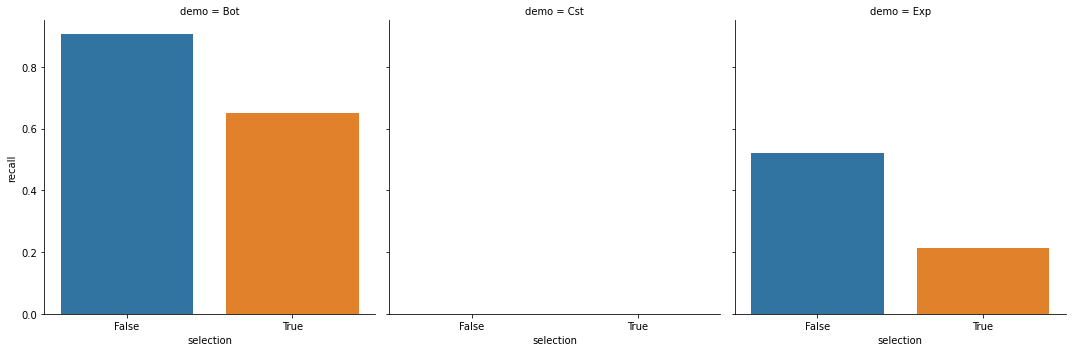

In [48]:
#original data recall
sns.catplot(data=df_recall_tot_ori, y="recall",x="selection", col="demo", kind="bar", legend_out=True)
#plt.savefig('/home/mathieu/Bureau/fig/origrecall.png', transparent=False)

In [27]:
df_rb = dforiginal.groupby(["selection"]).apply(precision_bottle).to_frame("precision").reset_index()
df_rb['demo']='Bot'
df_re = dforiginal.groupby(["selection"]).apply(precision_expan).to_frame("precision").reset_index()
df_re['demo']='Exp'
df_rc = dforiginal.groupby(["selection"]).apply(precision_cst).to_frame("precision").reset_index()
df_rc['demo']='Cst'
df_precision_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
df_precision_tot_ori

selection  precision demo
0      False   0.343675  Bot
1       True   0.234899  Bot
0      False   0.000000  Cst
1       True   0.000000  Cst
0      False   0.753731  Exp
1       True   0.309278  Exp

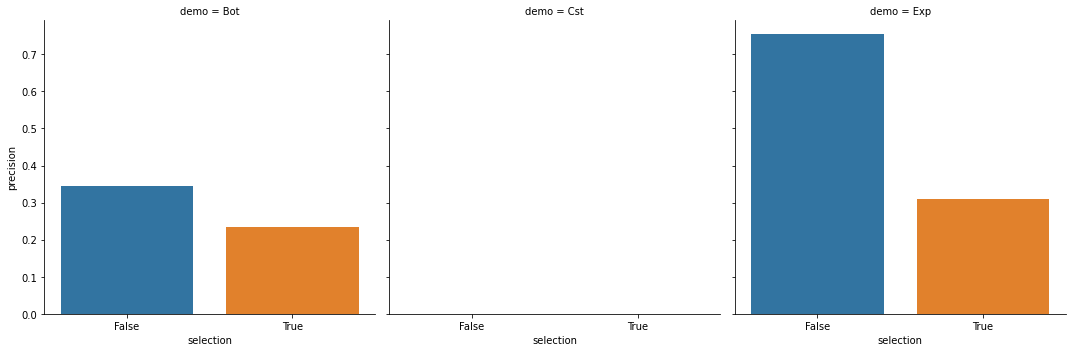

In [28]:
#original data precision
sns.catplot(data=df_precision_tot_ori, y="precision",x="selection", col="demo", kind="bar", legend_out=True)

<h1>DAMAGE<h1>

In [29]:
df_rb = dfres.groupby(["selection","error_rate", "coverage"]).apply(recall_bottle).to_frame("recall").reset_index()
df_rb['demo']='Bot'
df_re = dfres.groupby(["selection","error_rate", "coverage"]).apply(recall_expan).to_frame("recall").reset_index()
df_re['demo']='Exp'
df_rc = dfres.groupby(["selection","error_rate", "coverage"]).apply(recall_cst).to_frame("recall").reset_index()
df_rc['demo']='Cst'

In [30]:
df_recall_tot_damaged = pd.concat([df_rb, df_rc,df_re],axis=0)

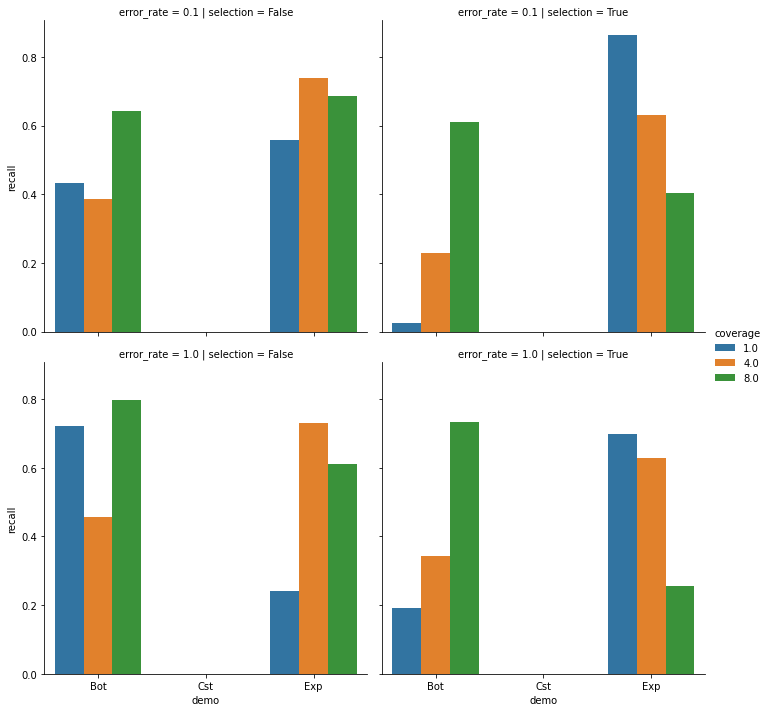

In [31]:
#damaged data recall
chart = sns.catplot(data=df_recall_tot_damaged, y="recall", x="demo", hue="coverage", row="error_rate", col="selection", kind="bar", legend_out=True)

In [32]:
df_rb = dfres.groupby(["selection","error_rate", "coverage"]).apply(precision_bottle).to_frame("precision").reset_index()
df_rb['demo']='Bot'
df_re = dfres.groupby(["selection","error_rate", "coverage"]).apply(precision_expan).to_frame("precision").reset_index()
df_re['demo']='Exp'
df_rc = dfres.groupby(["selection","error_rate", "coverage"]).apply(precision_cst).to_frame("precision").reset_index()
df_rc['demo']='Cst'
df_precision_tot_damaged = pd.concat([df_rb, df_rc,df_re],axis=0)

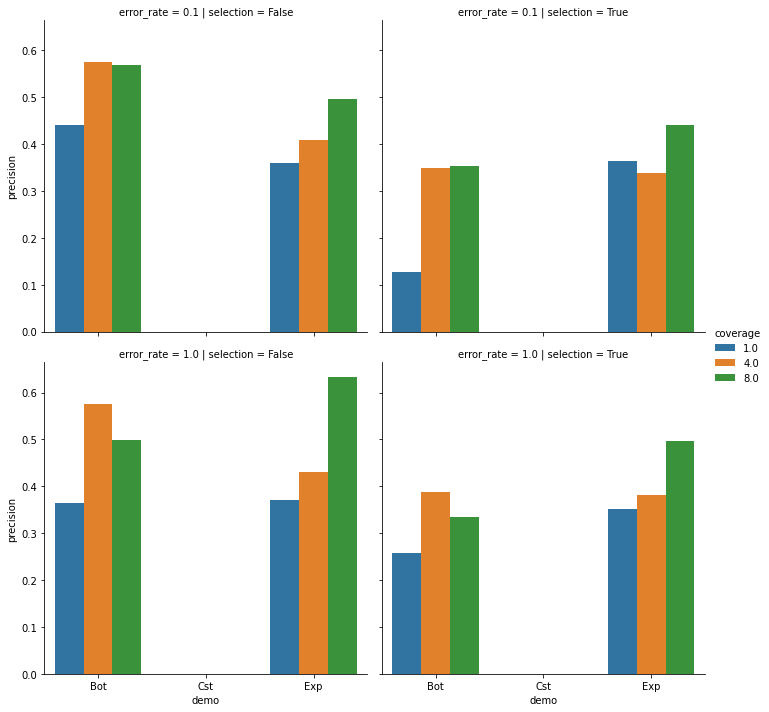

In [33]:
#damaged data precision
sns.catplot(data=df_precision_tot_damaged, y="precision", x="demo", hue="coverage", row="error_rate", col="selection", kind="bar", legend_out=True)

<h1>Validation<h1>

In [34]:
dfvalid = pd.read_csv('/media/mathieu/crucialmx300/skyline/validEvent20.csv', sep=",", header=0)

In [35]:
dfvalid.groupby(["selection", "observed_class"]).expected_class.value_counts().unstack()

expected_class               0    1     2
selection observed_class                 
False     0               2767  817  1126
          2                503  333  4944
True      0               2618  670  1168
          2                592  270  4191

In [36]:
pd.crosstab(dfvalid['expected_class'],dfvalid['observed_class'])

observed_class     0     2
expected_class            
0               5385  1095
1               1487   603
2               2294  9135

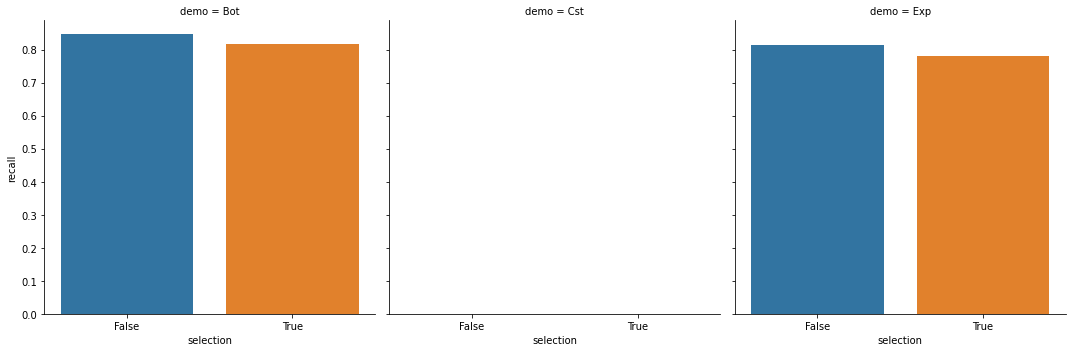

In [37]:

df_rb = dfvalid.groupby(["selection"]).apply(recall_bottle).to_frame("recall").reset_index()
df_rb['demo']='Bot'
df_re = dfvalid.groupby(["selection"]).apply(recall_expan).to_frame("recall").reset_index()
df_re['demo']='Exp'
df_rc = dfvalid.groupby(["selection"]).apply(recall_cst).to_frame("recall").reset_index()
df_rc['demo']='Cst'
df_recall_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
#original data recall
sns.catplot(data=df_recall_tot_ori, y="recall",x="selection", col="demo", kind="bar", legend_out=True)

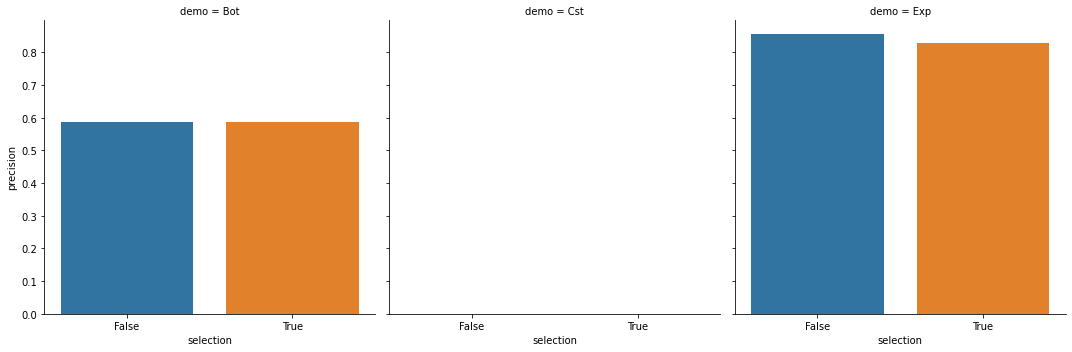

In [38]:
df_rb = dfvalid.groupby(["selection"]).apply(precision_bottle).to_frame("precision").reset_index()
df_rb['demo']='Bot'
df_re = dfvalid.groupby(["selection"]).apply(precision_expan).to_frame("precision").reset_index()
df_re['demo']='Exp'
df_rc = dfvalid.groupby(["selection"]).apply(precision_cst).to_frame("precision").reset_index()
df_rc['demo']='Cst'
df_precision_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
df_precision_tot_ori
#original data precision
sns.catplot(data=df_precision_tot_ori, y="precision",x="selection", col="demo", kind="bar", legend_out=True)

<h1>Beast<h1>

In [39]:
df = pd.read_csv('/media/mathieu/crucialmx300/skyline/beastResult.csv', sep=";", header=0)

In [40]:
import re
df['demo']=''
for i in range(df.shape[0]):
    
    num=re.findall(r'\d+_', df.loc[i,'scenario'])[0][:-1]
    expected_class, demo, selection = compute_expected_class('scenario_'+num)
     
    df.loc[i,'demo']=demo

In [41]:
def percentage(grp):
    return len(grp) / sum(df.demo == grp.demo[0])

dfp = df.groupby(["demo",'variation']).apply(percentage).to_frame("percentage").reset_index()

In [42]:
dfp

demo  variation  percentage
0  Bot   constant    0.701754
1  Bot  variation    0.298246
2  Cst   constant    0.835821
3  Cst  variation    0.164179
4  Exp   constant    0.237288
5  Exp  variation    0.762712

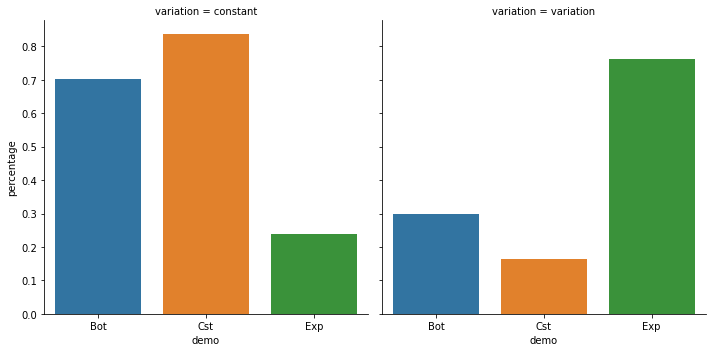

In [43]:
sns.catplot(data=dfp, y="percentage",x="demo", col="variation", kind="bar", legend_out=True)